In [8]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support

In [9]:
## Anamoly detection for tabular data using AutoEncoder
## This is just simple demonstration so we will use synthetic data
# Generate synthetic tabular data
np.random.seed(64)
n_samples = 1000
n_features = 10

# Good data (normal distribution)
good_data = np.random.normal(0, 1, (n_samples, n_features))

# Anomalies (outliers)
n_anomalies = 50
anomalies = np.random.uniform(-10, 10, (n_anomalies, n_features))

# Combine data
data = np.vstack([good_data, anomalies])
labels = np.array([0] * n_samples + [1] * n_anomalies)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

In [10]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Initialize the model
input_dim = X_train.shape[1]
hidden_dim = 8
autoencoder = Autoencoder(input_dim, hidden_dim)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

In [11]:
num_epochs = 50
batch_size = 32
train_loader = torch.utils.data.DataLoader(X_train, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    autoencoder.train()
    train_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        output = autoencoder(batch)
        loss = criterion(output, batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss/len(train_loader):.4f}')

Epoch [1/50], Loss: 1.0313
Epoch [2/50], Loss: 1.0183
Epoch [3/50], Loss: 1.0131
Epoch [4/50], Loss: 0.9995
Epoch [5/50], Loss: 1.0121
Epoch [6/50], Loss: 1.0230
Epoch [7/50], Loss: 1.0311
Epoch [8/50], Loss: 0.9570
Epoch [9/50], Loss: 1.0140
Epoch [10/50], Loss: 0.9287
Epoch [11/50], Loss: 0.9144
Epoch [12/50], Loss: 0.8969
Epoch [13/50], Loss: 0.8831
Epoch [14/50], Loss: 0.8683
Epoch [15/50], Loss: 0.8564
Epoch [16/50], Loss: 0.8480
Epoch [17/50], Loss: 0.8362
Epoch [18/50], Loss: 0.8262
Epoch [19/50], Loss: 0.8200
Epoch [20/50], Loss: 0.8123
Epoch [21/50], Loss: 0.8047
Epoch [22/50], Loss: 0.8171
Epoch [23/50], Loss: 0.8411
Epoch [24/50], Loss: 0.8351
Epoch [25/50], Loss: 0.8240
Epoch [26/50], Loss: 0.7661
Epoch [27/50], Loss: 0.7617
Epoch [28/50], Loss: 0.7528
Epoch [29/50], Loss: 0.7424
Epoch [30/50], Loss: 0.7350
Epoch [31/50], Loss: 0.7261
Epoch [32/50], Loss: 0.7216
Epoch [33/50], Loss: 0.7195
Epoch [34/50], Loss: 0.7112
Epoch [35/50], Loss: 0.7082
Epoch [36/50], Loss: 0.7369
E

In [12]:
autoencoder.eval()
with torch.no_grad():
    test_output = autoencoder(X_test)
    reconstruction_error = torch.mean((X_test - test_output) ** 2, dim=1).numpy()

# Set a threshold for anomaly detection
threshold = np.percentile(reconstruction_error, 95)  # 95th percentile as threshold

# Detect anomalies
anomalies_detected = reconstruction_error > threshold

# Evaluate performance
precision, recall, f1, _ = precision_recall_fscore_support(y_test, anomalies_detected, average='binary')
print(f'Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1:.2f}')

Precision: 1.00, Recall: 0.85, F1-Score: 0.92


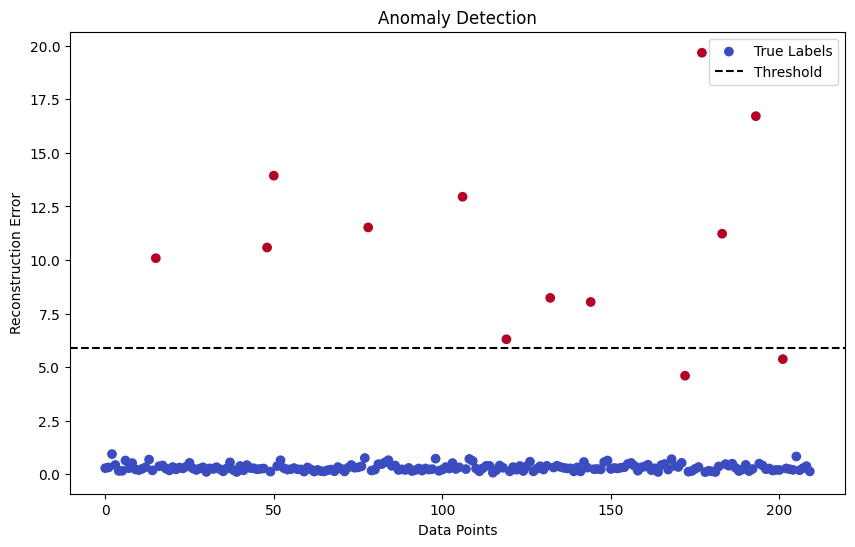

In [13]:
import matplotlib.pyplot as plt

# Plot reconstruction error vs. true labels
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), reconstruction_error, c=y_test, cmap='coolwarm', label='True Labels')
plt.axhline(threshold, color='black', linestyle='--', label='Threshold')
plt.xlabel('Data Points')
plt.ylabel('Reconstruction Error')
plt.title('Anomaly Detection')
plt.legend()
plt.show()